# Applied Data Science - Exercise 3

This is the third of six exercises in the course T-786-APDS Applied Data Science at Reykjavik University.

## Preparation

Please read chapters 3, 5, 6 and 7 of the textbook before the lab. Also skim over chapter 4 and make sure you are familiar with the theory.


## Task

This exercise continues from where the previous exercise left off. Having explored the car listings dataset and prepared it for machine learning algorithms, you will now train regression models in order to predict the listed car price.

You will also train classification models on the MSRP dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
# Check python version.
# This code should run for python version >=3.6

print("python", sys.version)

python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]


## Creating the training and test sets

We repeat the steps from the first exercise to split the data into training and test sets, making sure that we use the same `random_state` as before.

In [4]:
vehicles = pd.read_csv("../data/vehicles.csv", index_col=0)

In [5]:
reduced_df = vehicles.copy()
reduced_df = reduced_df[reduced_df['price'] > 0]
reduced_df = reduced_df[reduced_df['price'].notna()]
reduced_df = reduced_df[reduced_df['price'] < 1000000]
reduced_df = reduced_df[~((reduced_df.manufacturer.isnull()) & (reduced_df.manufacturer.isnull()))]
reduced_df = reduced_df.drop(columns=[
    'county', 
    'id', 
    'region_url', 
    'url', 
    'image_url',
    'VIN'
])

In [6]:
train_set, test_set = train_test_split(reduced_df, test_size=0.1, random_state=123)

In [7]:
def preprocess(df_in):
    
    df = df_in.copy()
    
    N = 50
    topN_models = df.model.value_counts().head(N).index.to_numpy()
    df.loc[~df['model'].isin(topN_models),'model'] = 'unknown'
    top_models = list(train_set.model.unique())
    
    df = df.drop(columns=[
        'size', 
        'drive', 
        'lat', 
        'long', 
        'posting_date', 
        'paint_color', 
        'description',
        'state',
        'region'
    ])
    
    df.loc[~df['model'].isin(top_models),'model'] = 'unknown'
    
    df = df.dropna(subset=['year', 'odometer','manufacturer'])
    df.fillna({'type':'unknown', 'title_status':'clean', 'fuel':'gas', 'cylinders':'unknown', 'transmission':'automatic', 'condition':'good'}, inplace=True)   
    
    X = df.drop('price', axis=1)
    y = df['price'].copy()
    
    return(X,y)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X, y = preprocess(train_set)

num_attribs = list(X.select_dtypes('number'))
cat_attribs = list(X.select_dtypes('object'))


pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

X_prepared = pipeline.fit_transform(X)

## Regression models

**Task:** Train a linear regression model on the data and print the resulting mean squared error, root mean squared error, mean absolute error and mean absolute percentage error.

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

linear_model = LinearRegression()
linear_model.fit(X_prepared, y)
mae = mean_absolute_error(y, linear_model.predict(X_prepared))
mse = mean_squared_error(y, linear_model.predict(X_prepared))
mape = mean_absolute_percentage_error(y, linear_model.predict(X_prepared))

print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)

MAE: 7609.643140825161
MSE: 138113547.77904674
MAPE: 87.693343962747


**Task:** Train a `sklearn.tree.DecisionTreeRegressor` model. First train it on the full training set and then try 3-fold cross validation.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

tree_reg = DecisionTreeRegressor(random_state=123)
fitted = tree_reg.fit(X_prepared, y)

# Evaluate the model on the full training set
mae = mean_absolute_error(y, fitted.predict(X_prepared))
mse = mean_squared_error(y, fitted.predict(X_prepared))
mape = mean_absolute_percentage_error(y, fitted.predict(X_prepared))

# Perform 3-fold cross-validation
cv_results = cross_validate(
    tree_reg, X_prepared, y, cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"],
    return_train_score=True
)

In [ ]:
cv_mae = -cv_results["test_neg_mean_absolute_error"]
cv_mse = -cv_results["test_neg_mean_squared_error"]
cv_mape = -cv_results["test_neg_mean_absolute_percentage_error"]
print("Cross-validation results:")
print("CV MAE:", cv_mae)
print("CV MSE:", cv_mse)
print("CV MAPE:", cv_mape)

print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)


Cross-validation results:
CV MAE: [2899.82704092 2938.57464037 2901.20095   ]
CV MSE: [68318337.13801794 76928843.89848007 57853956.28625825]
CV MAPE: [29.49619122 36.80172851 34.78095754]
MAE: 57.273936428816846
MSE: 1069645.7876682733
MAPE: 7.379309711374425


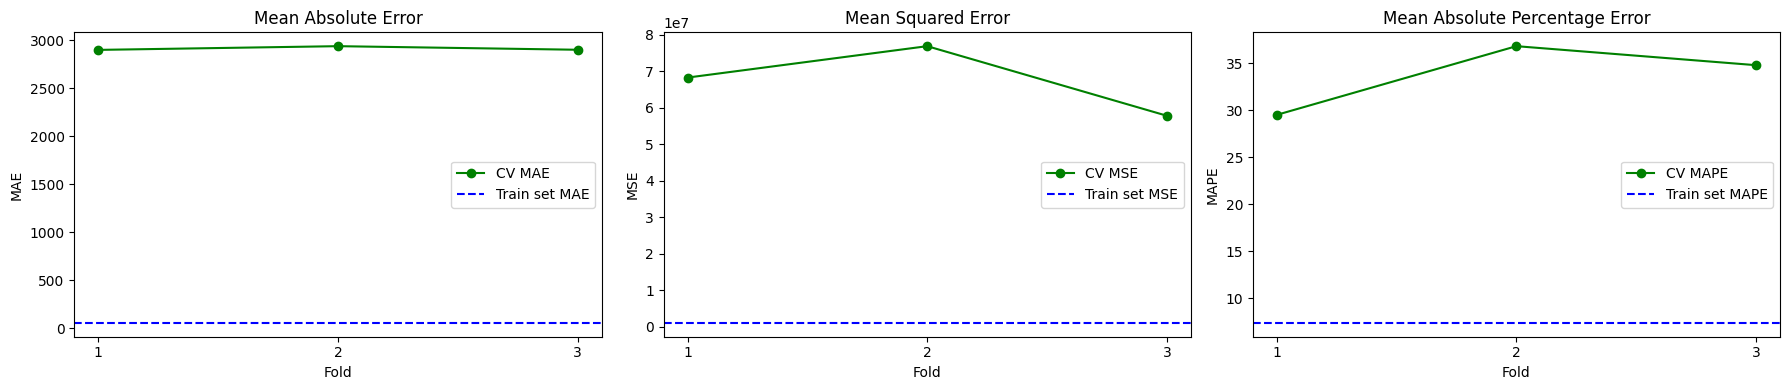

In [ ]:
folds = np.arange(1, 4)

plt.figure(figsize=(18, 4))

# MAE Plot
plt.subplot(1, 3, 1)
plt.plot(folds, cv_mae, marker='o', label='CV MAE', color='green')
plt.axhline(y=mae, color='blue', linestyle='--', label='Train set MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.xticks(folds)
plt.legend()

# MSE Plot
plt.subplot(1, 3, 2)
plt.plot(folds, cv_mse, marker='o', label='CV MSE', color='green')
plt.axhline(y=mse, color='blue', linestyle='--', label='Train set MSE')
plt.title('Mean Squared Error')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(folds)
plt.legend()

# MAPE Plot
plt.subplot(1, 3, 3)
plt.plot(folds, cv_mape, marker='o', label='CV MAPE', color='green')
plt.axhline(y=mape, color='blue', linestyle='--', label='Train set MAPE')
plt.title('Mean Absolute Percentage Error')
plt.xlabel('Fold')
plt.ylabel('MAPE')
plt.xticks(folds)
plt.legend()

plt.tight_layout()
plt.show()


**Question:** How does the error compare when training with/without cross validation?

**Answer:** `The errors are lower when training without cross validation. This is expected, since decision trees are prone to overfitting, and thus, high test errors.`

**Task:** Now train a `sklearn.ensemble.RandomForestRegressor` with 3-fold cross validation. Try to find a good combination of hyperparameters by manually changing the `n_estimators` and `max_features` arguments.

In [9]:
from sklearn.ensemble import RandomForestRegressor
import time

In [ ]:
start_time = time.time()
forest_reg = RandomForestRegressor(n_estimators=10, max_features=2, random_state=123)

cv_results = cross_validate(
    forest_reg, X_prepared, y, cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"],
    return_train_score=True
)

end_time = time.time()
print("Time:", (end_time - start_time) / 60, "minutes")


Time: 8.365467353661854 minutes


This took 8 minutes with only 10 n_estimators and 2 max_features. That is why I'm taking a sample of the training data to train the Random Forest Regressor with 3-fold cross validation.

In [16]:
n_samples = 3000
indicies = np.random.choice(X_prepared.shape[0], n_samples, replace=False)
X_sample = X_prepared[indicies]
y_sample = y.iloc[indicies]

maes = []
mses = [] 
mapes = []

In [ ]:
start_time = time.time()

for i in [50, 100, 200]:
    for j in [2, 6, 10]:
        forest_reg = RandomForestRegressor(n_estimators=i, max_features=j, random_state=123)
        cv_results = cross_validate(
            forest_reg, X_sample, y_sample, cv=3,
            scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"]
        )
        
        current_mean_mae = -cv_results["test_neg_mean_absolute_error"].mean()
        current_mean_mse = -cv_results["test_neg_mean_squared_error"].mean()
        current_mean_mape = -cv_results["test_neg_mean_absolute_percentage_error"].mean()
        maes.append([current_mean_mae, i, j])
        mses.append([current_mean_mse, i, j])
        mapes.append([current_mean_mape, i, j])
        print(f"n_estimators: {i}, max_features: {j}")
        print("MAE:", current_mean_mae)
        print("MSE:", current_mean_mse)
        print("MAPE:", current_mean_mape)

end_time = time.time()
print("Time:", (end_time - start_time) / 60, "minutes")
print("\n")
print("Lowest MAE:", min(maes, key=lambda x: x[0]))
print("Lowest MSE:", min(mses, key=lambda x: x[0]))
print("Lowest MAPE:", min(mapes, key=lambda x: x[0]))

n_estimators: 50, max_features: 2
MAE: 6571.023248888888
MSE: 452821694.8659136
MAPE: 58.73632045443935
n_estimators: 50, max_features: 6
MAE: 6471.965906666667
MSE: 468062765.4322173
MAPE: 58.034571935137485
n_estimators: 50, max_features: 10
MAE: 6476.850815555556
MSE: 480314151.2076308
MAPE: 59.63123888988137
n_estimators: 100, max_features: 2
MAE: 6508.084882539682
MSE: 452710269.1087006
MAPE: 56.725641344460065
n_estimators: 100, max_features: 6
MAE: 6369.516330793652
MSE: 461300647.5550681
MAPE: 55.68704725004733
n_estimators: 100, max_features: 10
MAE: 6298.121956666667
MSE: 468406098.22999984
MAPE: 58.14350970775191
n_estimators: 200, max_features: 2
MAE: 6510.34493126984
MSE: 457821256.5776414
MAPE: 57.36396271352243
n_estimators: 200, max_features: 6
MAE: 6333.169261984127
MSE: 464372742.1222632
MAPE: 56.07455313395152
n_estimators: 200, max_features: 10
MAE: 6271.402280079365
MSE: 462867869.94855636
MAPE: 57.24066569560781
Time: 0.5579482237497966 minutes


Lowest MAE: [np.f

The best combination of those tested above are n_estimators 200 and max_features 10. That makes me want to try even higher numbers.

In [ ]:
start_time = time.time()

for i in [300, 500, 1000]:
    for j in [5, 10, 15]:
        forest_reg = RandomForestRegressor(n_estimators=i, max_features=j, random_state=123)
        cv_results = cross_validate(
            forest_reg, X_sample, y_sample, cv=3,
            scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"]
        )
        current_mean_mae = -cv_results["test_neg_mean_absolute_error"].mean()
        current_mean_mse = -cv_results["test_neg_mean_squared_error"].mean()
        current_mean_mape = -cv_results["test_neg_mean_absolute_percentage_error"].mean()
        maes.append([current_mean_mae, i, j])
        mses.append([current_mean_mse, i, j])
        mapes.append([current_mean_mape, i, j])
        print(f"n_estimators: {i}, max_features: {j}")
        print("MAE:", current_mean_mae)
        print("MSE:", current_mean_mse)
        print("MAPE:", current_mean_mape)


end_time = time.time()
print("Time:", (end_time - start_time) / 60, "minutes")
print("\n")
print("Lowest MAE:", min(maes, key=lambda x: x[0]))
print("Lowest MSE:", min(mses, key=lambda x: x[0]))
print("Lowest MAPE:", min(mapes, key=lambda x: x[0]))

n_estimators: 300, max_features: 5
MAE: 5756.949747259259
MSE: 83299600.73612566
MAPE: 85.49906957783593
n_estimators: 300, max_features: 10
MAE: 5582.339280333334
MSE: 80208077.60295399
MAPE: 88.18822290041517
n_estimators: 300, max_features: 15
MAE: 5497.457684624339
MSE: 78938675.38033667
MAPE: 87.421825678361
n_estimators: 500, max_features: 5
MAE: 5733.820254209524
MSE: 82879985.90367483
MAPE: 85.4456894587746
n_estimators: 500, max_features: 10
MAE: 5564.110410422222
MSE: 79593803.92561857
MAPE: 87.67638229910217
n_estimators: 500, max_features: 15
MAE: 5491.716890819048
MSE: 78670391.5056514
MAPE: 87.17449751969859
n_estimators: 1000, max_features: 5
MAE: 5724.180970371429
MSE: 82648191.03439651
MAPE: 85.73759473194694
n_estimators: 1000, max_features: 10
MAE: 5555.536488944445
MSE: 79457741.72645243
MAPE: 87.73287357184536
n_estimators: 1000, max_features: 15
MAE: 5476.412594098412
MSE: 78353767.24989411
MAPE: 87.90159392644956
Time: 2.886273189385732 minutes


Lowest MAE: [np.

**Question:** What was the best combination of hyperparameters you found and what was the error?

**Answer:** `MAPE is lowest with 500 estimators and max 5 features, while both MAE and MSE are lowest with 1000 estimators and 15 max features. `

**New answer after more sampling:** I probably wouldn't have run it again with higher values if I'd sampled it properly in the start.

MAE was lowest with 200 estimators and 10 max features: 6271

MSE was lowest with 100 estimators and 2 max features: 452710269

MAPE was lowest with 100 estimators and 6 max features: 55



**Task:** Train a `RandomForestRegressor` model, this time using `sklearn.model_selection.GridSearchCV` to find a good combination of the hyperparameters `n_estimators` and `max_features`.

How long does the `GridSearchCV` take? 

*Hint*: You can use the `time` python module to record the time taken.

In [22]:
from sklearn.model_selection import GridSearchCV

start_time = time.time()

param_grid = [
    {
        'n_estimators': [100, 200, 300],
        'max_features': [5, 10, 15],
        'max_depth': [10, 20, 30]
    }
]
random_forest_reg = RandomForestRegressor(random_state=123)
grid_search = GridSearchCV(
    random_forest_reg, param_grid, cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"],
    refit="neg_mean_absolute_error"
)

grid_search.fit(X_sample, y_sample)

end_time = time.time()
print("Time:", (end_time - start_time) / 60, "minutes")
print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)
print("Best MSE:", -grid_search.cv_results_['mean_test_neg_mean_squared_error'][grid_search.best_index_])
print("Best MAPE:", -grid_search.cv_results_['mean_test_neg_mean_absolute_percentage_error'][grid_search.best_index_])


Time: 1.5584163427352906 minutes
Best parameters: {'max_depth': 30, 'max_features': 15, 'n_estimators': 300}
Best MAE: 5279.071686074761
Best MSE: 72355942.3862028
Best MAPE: 80.80600149972734


**Question:** What was the best combination of hyperparameters you found using `GridSearchCV`and what was the error?

**Answer:** `The best combination is 200 estimators and 10 max features, with MAE 6271.`

**Task:** Again, look for good hyperparameters for training a `RandomForestRegressor` model, but this time using `sklearn.model_selection.RandomSearchCV`.

In [17]:
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [2, 5, 10],
    'max_depth': [3, 8, 10],
}

random_forest_reg = RandomForestRegressor(random_state=123)
random_search = RandomizedSearchCV(
    random_forest_reg, param_grid, cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"],
    refit="neg_mean_absolute_error",
    random_state=123
)

random_search.fit(X_sample, y_sample)

end_time = time.time()
print("Time:", (end_time - start_time) / 60, "minutes")
print("Best parameters:", random_search.best_params_)
print("Best MAE:", -random_search.best_score_)
print("Best MSE:", -random_search.cv_results_['mean_test_neg_mean_squared_error'][random_search.best_index_])
print("Best MAPE:", -random_search.cv_results_['mean_test_neg_mean_absolute_percentage_error'][random_search.best_index_])

Time: 0.11378621260325114 minutes
Best parameters: {'n_estimators': 50, 'max_features': 10, 'max_depth': 10}
Best MAE: 6584.533692233551
Best MSE: 93079882.23784445
Best MAPE: 84.26924436236364


**Task:** Now try other regression models, including Polynomial Regression and SVM regression with different kernel types. Make sure you use cross validation and look for good hyperparameters.

In [ ]:
from sklearn.svm import SVR

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'epsilon': [0.01, 0.1, 0.5]
}

SVR_model = SVR(kernel='linear', C=1.0, epsilon=0.1)
grid_search = GridSearchCV(
    SVR_model, param_grid, cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"],
    refit="neg_mean_absolute_error"
)
grid_search.fit(X_sample, y_sample)
print("Best SVR parameters:", grid_search.best_params_)
print("Best SVR MAE:", -grid_search.best_score_)

Best SVR parameters: {'C': 10, 'degree': 2, 'epsilon': 0.5, 'kernel': 'linear'}
Best SVR MAE: 9253.187753071927


In [48]:
from sklearn.ensemble import GradientBoostingRegressor

n_samples = 1000
indicies = np.random.choice(X_prepared.shape[0], n_samples, replace=False)
X_sample = X_prepared[indicies]
y_sample = y.iloc[indicies]

gb_reg = GradientBoostingRegressor(random_state=123)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [2, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5]
}

random_search = RandomizedSearchCV(
    gb_reg, param_grid, n_iter=10, cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"],
    refit="neg_mean_absolute_error",
    random_state=123
)
random_search.fit(X_sample, y_sample)
print("Best Gradient Boosting parameters:", random_search.best_params_)
print("Best Gradient Boosting MAE:", -random_search.best_score_)

Best Gradient Boosting parameters: {'n_estimators': 200, 'max_features': 2, 'learning_rate': 0.1}
Best Gradient Boosting MAE: 6869.2267985120225


In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV

n_samples = 10
indicies = np.random.choice(X_prepared.shape[0], n_samples, replace=False)
X_sample = X_prepared[indicies]
y_sample = y.iloc[indicies]

poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linreg', LinearRegression())
])

param_grid = {
    'poly__degree': [2]
}
random_search = RandomizedSearchCV(
    poly_pipeline, param_grid, n_iter=1, cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "neg_mean_absolute_percentage_error"],
    refit="neg_mean_absolute_error",
    random_state=123
)
random_search.fit(X_sample, y_sample)

print("Best Polynomial MAE:", -random_search.best_score_)

Best Polynomial MAE: 9520.615209839276


**Question:** What models did you try and what was the best hyperparameter combination for the best model? Did you get a decrease in validation error?

Random Forest with 1000 estimators and 15 max features was the best model according to Mean Absolute Error. A close second is the Gradient Boosting Regressor with 50 estimators, 10 max features and learning rate 0.5.

**Task:** Retrain your best model on the full training set. What is the resulting mean squared error, root mean squared error, mean absolute error and mean absolute percentage error?

In [23]:
start_time = time.time()

random_forest_reg = RandomForestRegressor(random_state=123, n_estimators=300, max_features=15, max_depth=30)
random_forest_reg.fit(X_prepared, y)

end_time = time.time()
print("Time:", (end_time - start_time) / 60, "minutes")

print("MSE:", mean_squared_error(y, random_forest_reg.predict(X_prepared)))
print("RMSE:", np.sqrt(mean_squared_error(y, random_forest_reg.predict(X_prepared))))
print("MAE:", mean_absolute_error(y, random_forest_reg.predict(X_prepared)))
print("MAPE:", mean_absolute_percentage_error(y, random_forest_reg.predict(X_prepared)))

Time: 71.7279931227366 minutes
MSE: 18972381.85324358
RMSE: 4355.729772752618
MAE: 2262.9295181104053
MAPE: 32.20111648813969


In [24]:
import pickle

pickle.dump(pipeline, open("../models/pipeline.pkl", "wb"))
pickle.dump(random_forest_reg, open("../models/random_forest_model.pkl", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: '../models/pipeline.pkl'

In the upcoming lectures, you will learn about some more modeling techniques, including Deep Learning. We will be trying those techniques on our dataset as well, so we are not yet done with this training data. Thus, we will not evaluate our best model on the test data at this stage.

## Classification

Luxury cars probably have a different price distribution to other car categories. Can we distinguish between luxury cars and non-luxury cars without knowing the car's model, make and price?

We will now try classifying cars in the MSRP dataset into luxury and non-luxury categories. We will imagine that we do not have the  `model`, `make`, `msrp` and `popularity` attributes and see how accurately we can spot luxury cars.

Since the cars in the MSRP dataset are often assigned multiple market categories, we need to decide how to create a binary luxury/non-luxury variable. We will assume that the car is a luxury vehicle if one of the listed categories is `Luxury`.

In [7]:
msrp_df = pd.read_csv("../data/msrp_data.csv")

In [8]:
for col in msrp_df.columns:
    new_col = '_'.join(col.lower().split(' '))
    msrp_df.rename({col: new_col}, inplace=True, axis=1)

In [9]:
msrp_df['is_luxury'] = msrp_df.market_category.str.contains('Luxury')

In [10]:
msrp_df = msrp_df.drop(columns=['model','market_category', 'make', 'msrp', 'popularity'])

In [11]:
msrp_train_set, msrp_test_set = train_test_split(
    msrp_df.dropna(subset=['is_luxury']), 
    test_size=0.1, 
    random_state=123)
msrp_train_df = msrp_train_set.copy()

**Task:** Make sure you understand what the above code is doing and verify that `msrp_train_df` has the features we need.

**Task:** Get familiar with the training data, assuming now that `is_luxury` is our target variable.

In [12]:
print(msrp_train_df['is_luxury'].value_counts())
print(msrp_train_df['is_luxury'].value_counts(normalize=True)) # Porportion
msrp_train_df.head(10)

is_luxury
False    4411
True     2943
Name: count, dtype: int64
is_luxury
False    0.59981
True     0.40019
Name: proportion, dtype: float64


,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,is_luxury
2876,2016,premium unleaded (required),521.0,8.0,AUTOMATIC,all wheel drive,2.0,Midsize,Coupe,25,15,True
4564,2017,regular unleaded,325.0,6.0,AUTOMATIC,four wheel drive,4.0,Large,Crew Cab Pickup,23,18,False
7937,2016,premium unleaded (recommended),265.0,6.0,AUTOMATIC,front wheel drive,4.0,Large,4dr SUV,27,21,True
3373,2016,regular unleaded,184.0,4.0,AUTOMATIC,front wheel drive,4.0,Midsize,4dr SUV,33,26,False
8774,2003,flex-fuel (unleaded/E85),120.0,4.0,AUTOMATIC,rear wheel drive,2.0,Compact,Regular Cab Pickup,23,17,False
4882,2017,regular unleaded,164.0,4.0,AUTOMATIC,front wheel drive,4.0,Compact,4dr Hatchback,34,25,False
1012,1995,regular unleaded,236.0,4.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,24,15,True
5935,2001,regular unleaded,140.0,4.0,MANUAL,front wheel drive,4.0,Compact,Sedan,28,22,True
10765,2015,regular unleaded,138.0,4.0,AUTOMATIC,front wheel drive,4.0,Compact,4dr SUV,34,26,False
6486,2016,premium unleaded (required),386.0,8.0,AUTOMATIC,rear wheel drive,4.0,Large,Sedan,24,16,True


In [13]:
msrp_train_df.describe(include='all') 

,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,is_luxury
count,7354.000000,7354,7301.000000,7327.000000,7354,7354,7348.000000,7354,7354,7354.000000,7354.000000,7354
unique,NaN,9,NaN,NaN,5,4,NaN,3,16,NaN,NaN,2
top,NaN,regular unleaded,NaN,NaN,AUTOMATIC,front wheel drive,NaN,Midsize,4dr SUV,NaN,NaN,False
freq,NaN,3180,NaN,NaN,5218,2628,NaN,2868,1891,NaN,NaN,4411
mean,2012.064047,NaN,274.223394,5.756517,NaN,NaN,3.417665,NaN,NaN,27.072750,20.076285,NaN
std,6.315914,NaN,114.662404,1.924369,NaN,NaN,0.896068,NaN,NaN,9.634276,10.042547,NaN
min,1990.000000,NaN,55.000000,0.000000,NaN,NaN,2.000000,NaN,NaN,12.000000,7.000000,NaN
25%,2010.000000,NaN,190.000000,4.000000,NaN,NaN,2.000000,NaN,NaN,22.000000,16.000000,NaN
50%,2015.000000,NaN,263.000000,6.000000,NaN,NaN,4.000000,NaN,NaN,26.000000,18.000000,NaN
75%,2016.000000,NaN,320.000000,6.000000,NaN,NaN,4.000000,NaN,NaN,30.000000,22.000000,NaN


**Task:** Prepare the MSRP training data for machine learning algorithms, treating `is_luxury` as the target variable.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def preprocess_msrp(df_in):

    df = df_in.copy()

    X = df.drop('is_luxury', axis=1)
    y = df['is_luxury'].copy()

    df.fillna(
        {
            'year': df['year'].median(), 
            'engine_fuel_type': 'regular unleaded', 
            'engine_hp': df['engine_hp'].median(), 
            'engine_cylinders': df['engine_cylinders'].median(), 
            'transmission_type': 'automatic',
            'driven_wheels': 'rear wheel drive', 
            'number_of_doors': 'four', 
            'vehicle_size': 'mid-size', 
            'vehicle_style': 'sedan', 
            'highway_mpg': df['highway_mpg'].median(), 
            'city_mpg': df['city_mpg'].median()
        }, inplace=True)

    return(X,y)

X, y = preprocess_msrp(msrp_train_set)

num_attribs = list(X.select_dtypes('number'))
cat_attribs = list(X.select_dtypes('object'))

pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

X_prepared = pipeline.fit_transform(X)
    

**Task:** Train binary classification models on the MSRP training data. Try different models, including Logistic Regression, Decision Tree, Random Forest, Stochastic Gradient Descent classifier and SVM. For each classifier, look at the accuracy, confusion matrix, precision, recall and F$_1$ score. When applicable, plot precision-recall curves for different thresholds and calculate the area under the curve.

Logistic Regression:
Accuracy: 0.8101713353277128
Confusion Matrix:
 [[3777  634]
 [ 762 2181]]
Precision: 0.7747779751332149
Recall: 0.7410805300713558
F1 Score: 0.7575547064953109



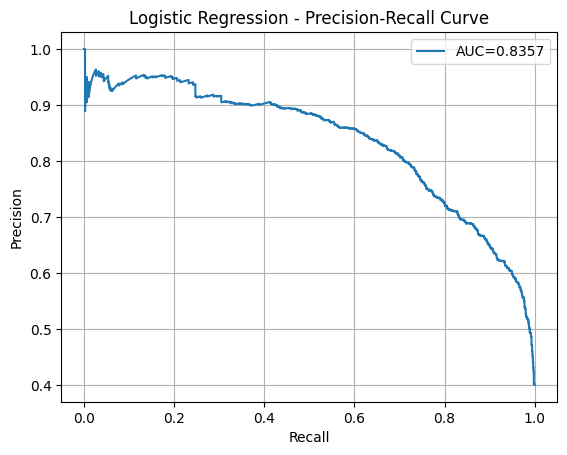

Decision Tree:
Accuracy: 0.9959205874354093
Confusion Matrix:
 [[4398   13]
 [  17 2926]]
Precision: 0.9955767267778156
Recall: 0.9942235813795447
F1 Score: 0.9948996939816389



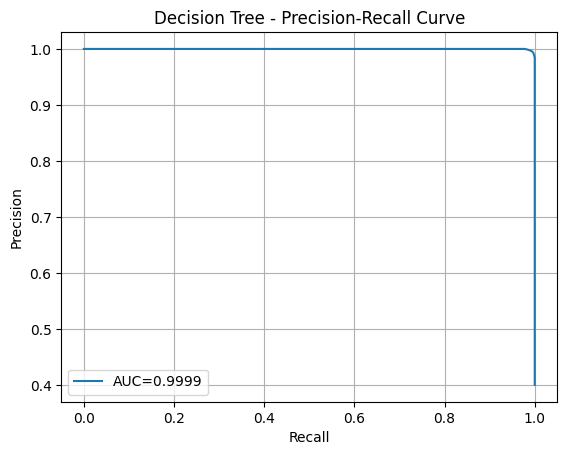

Random Forest:
Accuracy: 0.9959205874354093
Confusion Matrix:
 [[4392   19]
 [  11 2932]]
Precision: 0.9935615045747205
Recall: 0.9962623173632348
F1 Score: 0.9949100780454699



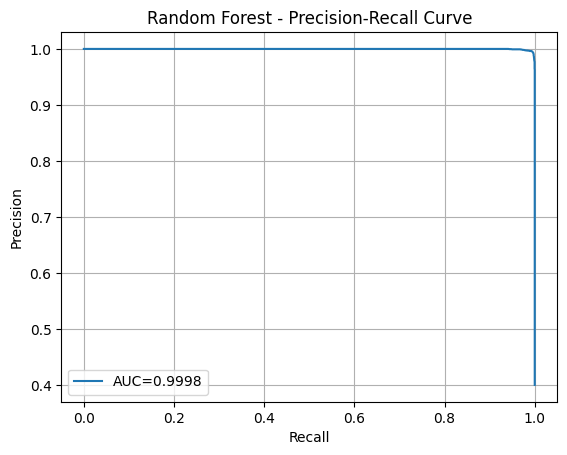

SGD Classifier:
Accuracy: 0.7828392711449551
Confusion Matrix:
 [[3634  777]
 [ 820 2123]]
Precision: 0.7320689655172414
Recall: 0.7213727488956847
F1 Score: 0.7266814992298477



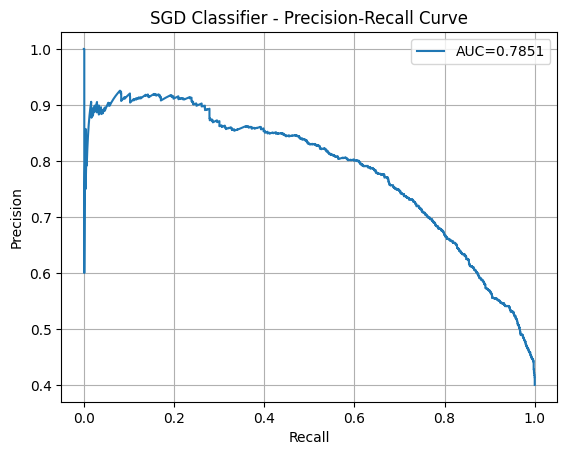

SVM:
Accuracy: 0.8966548816970357
Confusion Matrix:
 [[4099  312]
 [ 448 2495]]
Precision: 0.8888493053081582
Recall: 0.8477743798844716
F1 Score: 0.8678260869565217



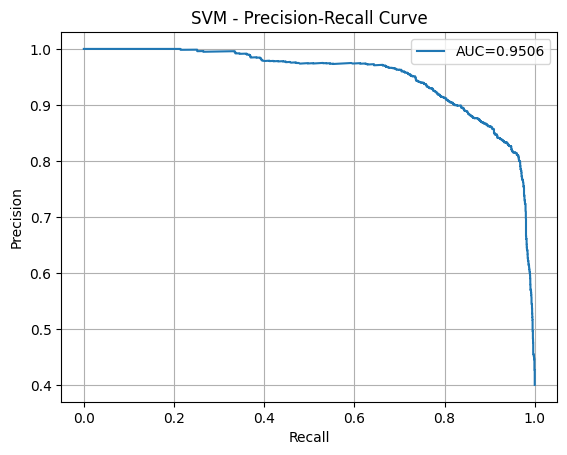

In [15]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve
# Impute NaN values using SimpleImputer
from sklearn.impute import SimpleImputer

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SGD Classifier": SGDClassifier(),
    "SVM": SVC(probability=True)
}

# Create an imputer to replace NaN values with the median
imputer = SimpleImputer(strategy='median')

# Fit and transform the imputer on the data
X_prepared_imputed = imputer.fit_transform(X_prepared.toarray())

# Convert boolean values in 'y' to integers (0 and 1)
y = y.astype(int)  # This will convert True to 1 and False to 0

for name, clf in classifiers.items():
    print(f"{name}:")
    clf.fit(X_prepared_imputed, y)  # Use the imputed data and converted 'y' for training
    y_pred = clf.predict(X_prepared_imputed)  # Use the imputed data for prediction
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    print()

    if hasattr(clf, "decision_function") or hasattr(clf, "predict_proba"):
        if hasattr(clf, "decision_function"):
            y_scores = clf.decision_function(X_prepared_imputed)
        if hasattr(clf, "predict_proba"):
            y_scores = clf.predict_proba(X_prepared_imputed)[:, 1]

        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
        pr_auc = auc(recalls, precisions)

        plt.plot(recalls, precisions, label=f'AUC={pr_auc:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{name} - Precision-Recall Curve')
        plt.legend()
        plt.grid()
        plt.show()

**Question:** What was the best model you found?

Random Forest (and Decision tree?)

**Task:** Validate your best model on the MSRP test data. How does it perform?

Random Forest - Test Set Evaluation:
Accuracy: 0.9853300733496333
Confusion Matrix:
 [[467   6]
 [  6 339]]
Precision: 0.9826086956521739
Recall: 0.9826086956521739
F1 Score: 0.9826086956521739


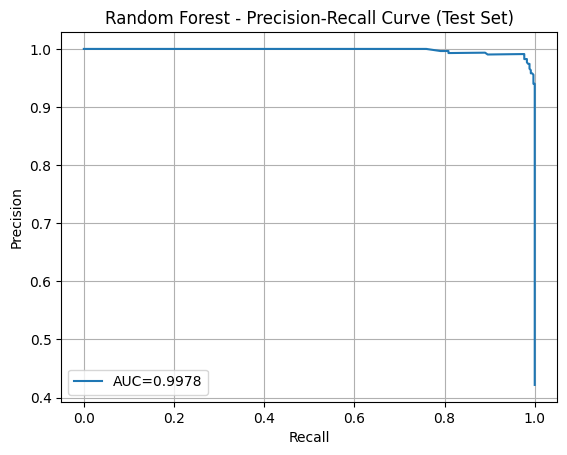

In [17]:
X, y = preprocess_msrp(msrp_train_set)

num_attribs = list(X.select_dtypes('number'))
cat_attribs = list(X.select_dtypes('object'))

pipeline = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_attribs),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder())]), cat_attribs)
])

X_prepared = pipeline.fit_transform(X)

#Convert y to numerical values (0 and 1) before fitting the model
y = y.astype(int)  # Convert True to 1 and False to 0

rand_forest_clf = RandomForestClassifier()
rand_forest_clf.fit(X_prepared, y)

X_test, y_test = preprocess_msrp(msrp_test_set)

y_pred = rand_forest_clf.predict(pipeline.transform(X_test))

print("Random Forest - Test Set Evaluation:")

# Convert y_test to numerical values (0 and 1) before calculating accuracy
y_test_int = y_test.astype(int) # Convert True to 1 and False to 0
print("Accuracy:", accuracy_score(y_test_int, y_pred))  # Use y_test_int

print("Confusion Matrix:\n", confusion_matrix(y_test_int, y_pred)) # Use y_test_int
print("Precision:", precision_score(y_test_int, y_pred)) # Use y_test_int
print("Recall:", recall_score(y_test_int, y_pred)) # Use y_test_int
print("F1 Score:", f1_score(y_test_int, y_pred)) # Use y_test_int

# Precision-Recall curve for the test set
y_scores = rand_forest_clf.predict_proba(pipeline.transform(X_test))[:, 1] # Changed this line
precisions, recalls, thresholds = precision_recall_curve(y_test_int, y_scores) # Use y_test_int
pr_auc = auc(recalls, precisions)

# Plot the Precision-Recall curve
plt.plot(recalls, precisions, label=f'AUC={pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest - Precision-Recall Curve (Test Set)')
plt.legend()
plt.grid()
plt.show()